In [1]:
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__)

2.3.1


In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 22s 0us/step


In [6]:
print(os.listdir(dataset_dir))

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']


In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [11]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [13]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review: ", text_batch.numpy()[i])
        print("Label: ", label_batch.numpy()[i])

Review:  b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Label:  1
Review:  b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made fo

In [14]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [15]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [16]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [17]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [28]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(standardize=custom_standardization, max_tokens=max_features, output_mode='int', output_sequence_length=sequence_length)

In [29]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [30]:
def vectorize_text(text,label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [31]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("First Review: ", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized Review", vectorize_text(first_review, first_label))

First Review:  tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized Review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[9249,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1013,   36,  262,   38,    9, 3923,   35,    2,    1,   43,
         382, 5216,   16,    4, 1115,   12,   43, 5734,  300,    2,   83,
         225,   55, 3208, 3934,   20,  978,   18,   51,   55, 3208,  250,
         320,   34,   40, 4381,    3,  294,   58,   44,    6, 2906,    4,
        6744,   92,   22,  184,    2, 4915,  100, 1221,  337

In [36]:
print("9249 --->", vectorize_layer.get_vocabulary()[9249])
print("15 --->", vectorize_layer.get_vocabulary()[15])
print("Vocabulary Size = {}".format(len(vectorize_layer.get_vocabulary())))

9249 ---> recipe
15 ---> for
Vocabulary Size = 10000


In [37]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
embedding_dim = 16

In [40]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [42]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 28s 45ms/step - loss: 0.6642 - binary_accuracy: 0.6960 - val_loss: 0.6153 - val_binary_accuracy: 0.7708
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5480 - binary_accuracy: 0.8016 - val_loss: 0.4990 - val_binary_accuracy: 0.8218
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4450 - binary_accuracy: 0.8446 - val_loss: 0.4211 - val_binary_accuracy: 0.8464
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3786 - binary_accuracy: 0.8669 - val_loss: 0.3746 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3358 - binary_accuracy: 0.8791 - val_loss: 0.3459 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3048 - binary_accuracy: 0.8893 - val_loss: 0.3268 - val_binary_accuracy: 0.8694
Epoch 7/10
625/625 [==============================] - 2s 3ms/s

In [43]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 96s 123ms/step - loss: 0.3111 - binary_accuracy: 0.8722
Loss:  0.31107422709465027
Accuracy:  0.8722000122070312


In [44]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

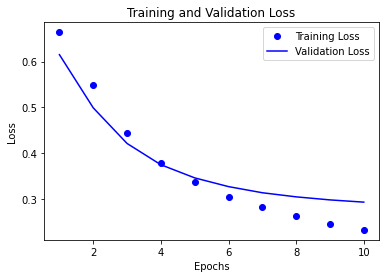

In [45]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

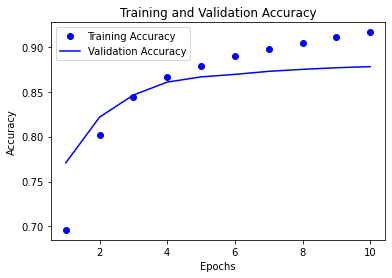

In [46]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 12s 16ms/step - loss: 0.3111 - accuracy: 0.8722
0.8722000122070312


In [50]:
examples = [
    'The movie was great!',
    'That movie was terrible!',
    'The movie was ok...'
]

export_model.predict(examples)

array([[0.61091   ],
       [0.35176152],
       [0.43468434]], dtype=float32)